# Bayes4MADMAX

### Bayesian Analysis

This notebook shows you how to handle the Bayesian Analysis with BAT.jl. It assumes background reduced data, so look at the `BGfit_demo` notebook first!

As usual first load the `Bayes4MADMAX` package, but now we also need the BAT package explicitly:

In [16]:
using Revise
using BAT

In [24]:
push!(LOAD_PATH, normpath(@__DIR__, "..", "src"))
using Bayes4MADMAX

Again read data as in `BGfit_demo` notebook, but now you can also read background fit parameters.

Initialize the likelihood function and prior as needed by BAT and initialize the PosteriorDensity therefrom.

In [34]:
dataset = "simulated/tests"
fname = "test"
folder = "Bg_fits_221"

data = read_data(fname, dataset, "processed_data/"*folder)
ex = read_struct(Experiment, fname, dataset)
signal = read_struct(Theory, fname, dataset)
bg = read_bgfit(fname, dataset, "processed_data/"*folder)

likelihood = make_like(data, fit_function, ex, bg)
prior = make_prior(data, ex; pow=:loggaγγ)

posterior = PosteriorDensity(likelihood, prior)

Reading from /home/th347/diehl/Documents/2103-Bayes/data/simulated/tests/processed_data/Bg_fits_221


PosteriorDensity(objectid = 0x3c8a99011c119cb0, varshape = NamedTupleShape((:ma, :sig_v, :log_gag)}(…))

Do the actual Bayesian analysis. `sampling` collects all necessary arguments, three viable options are given below. This should take a couple of minutes to run. For bigger applications make sure to set `JULIA_NUM_THREADS=nchains` before starting up Julia for maximal speed.

In [35]:
# Below are alternatives for the sampling algorithm
sampling = MCMCSampling(mcalg = MetropolisHastings(tuning=AdaptiveMHTuning()), nsteps = 5*10^4, nchains = 4, burnin = MCMCMultiCycleBurnin(max_ncycles=100))
#sampling = MCMCSampling(mcalg = HamiltonianMC(), nsteps = 2*10^3, nchains = 4, burnin = MCMCMultiCycleBurnin(max_ncycles=3))
#using UltraNest
#sampling = ReactiveNestedSampling()

out = bat_sample(posterior, sampling)

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 2 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc

(result = DensitySampleVector(length = 71372, varshape = NamedTupleShape((:ma, :sig_v, :log_gag)}(…)), result_trafo = DensitySampleVector(length = 71372, varshape = ValueShapes.ArrayShape{Float64, 1}((3,))), trafo = DistributionTransform(BAT.StandardMvNormal{Float64}(_dim=3), NamedTupleDist{(:ma, :sig_v, :log_gag)}(…)), generator = MCMCSampleGenerator(MHIterator(id = 36, nsamples = 19128, density = PosteriorDensity(objectid = 0xb0e5c82dab4abd40, varshape = ValueShapes.ArrayShape{Real, 1}((3,)))), …), isvalid = true, optargs = (rng = Random123.Philox4x{UInt64, 10}(0x7f70db57dffd8659, 0x8b9c36c3957b958e, 0x3139c2be58f42aef, 0x115b024499354684, 0x321f5e57d7e61c5a, 0xbea648f2938f67f7, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x8000020100000000, 3), algorithm = MCMCSampling{MetropolisHastings{BAT.MvTDistProposal, RepetitionWeighting{Int64}, AdaptiveMHTuning}, PriorToGaussian, MCMCChainPoolInit, MCMCMultiCycleBurnin, BrooksGelmanConvergence, typeof(BAT.nop_func)}
  mcalg: 

Save the samples. This will store the samples, the prior and the (possible) signal model correction due to the background fit into a new folder called "processed_data/Bg_fits_sg".

In [36]:
save_samples(out, prior, bg, fname, dataset; overwrite=true, newfolder=folder)

Now let us look at our samples!

In [37]:
samples = read_samples(fname, dataset; folder=folder)
prior = read_prior(fname, dataset; folder=folder)

NamedTupleDist((ma = Distributions.Uniform{Float64}(a=45.509788902341725, b=45.528655818370886), sig_v = Distributions.Normal{Float64}(μ=218.0, σ=39.0), log_gag = Distributions.Uniform{Float64}(a=-26.0, b=-19.0)))

`BAT.jl` overwrites the usual plotting command:

Means: (ma = 45.513010772175754, sig_v = 197.87459409342284, log_gag = -22.908372094407497)
Stds: (ma = 4.676461071232843e-6, sig_v = 27.691860946232595, log_gag = 0.0437557963070317)


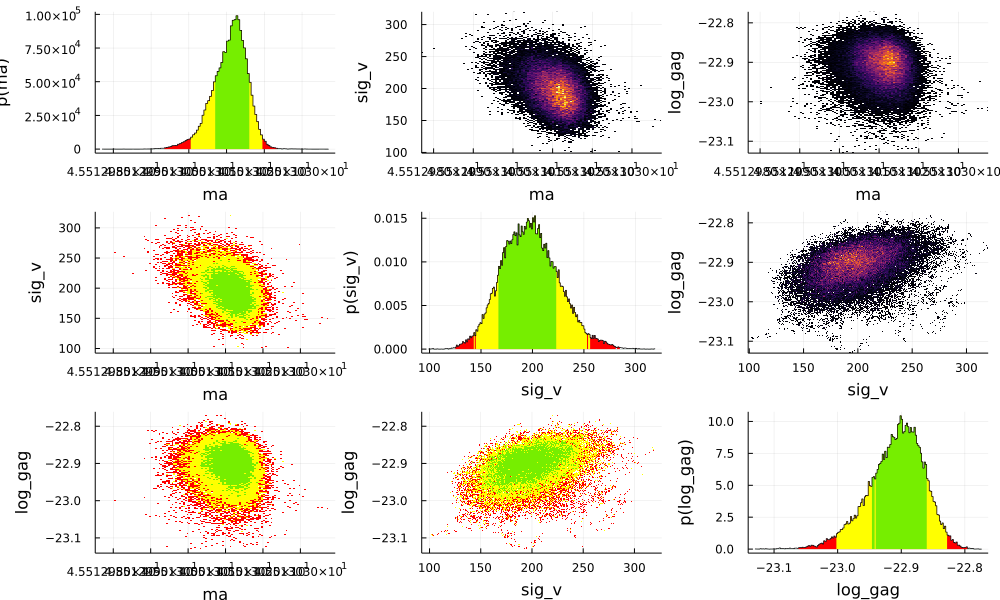

In [38]:
using Plots
using Statistics

println("Means: $(mean(samples)[1])")
println("Stds: $(std(samples)[1])")

plot(samples)

Did we find the axion?

(ma = 45.513010772175754, sig_v = 197.87459409342284, log_gag = -22.908372094407497)


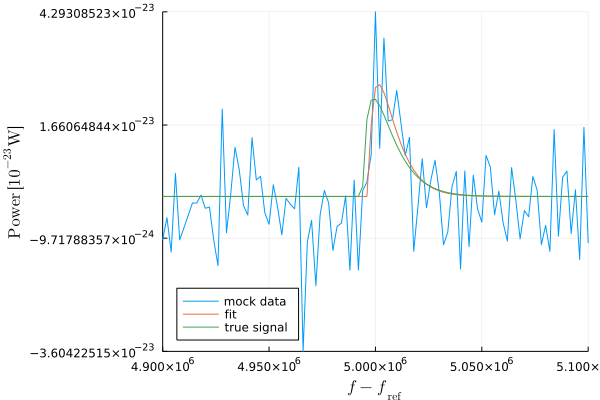

In [39]:
plot_fit(samples, data, ex; truths=signal, xrange=(4.9e6,5.1e6))